In [1]:
import pandas as pd
import numpy as np
import os
from random import sample

from PIL import Image
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.metrics import mean_squared_error

from visual_semantic_embedding import tools, evaluation


Using TensorFlow backend.


In [3]:
path_to_model =  '/home/lichi/jupiter/imaginarium/pretrained_models/coco.npz'
#path_to_model_f30k =  '/home/lichi/jupiter/imaginarium/pretrained_models/f30k.npz'
model = tools.load_model(path_to_model = path_to_model)
#model_f30k = tools.load_model(path_to_model = path_to_model_f30k)

#evaluation.evalrank(model, data='f8k', split='test')


/home/lichi/jupiter/imaginarium/pretrained_models/coco.npz
Loading dictionary...


IOError: [Errno 2] No such file or directory: '/home/lichi/jupiter/imaginarium/pretrained_models/coco.npz.dictionary.pkl'

#### Читаем картинки, строим эмбеддинги и извлекаем из них VGG19 фичи

In [4]:
base_model = VGG19(weights='imagenet', include_top=True)
model_vgg19 = Model(input=base_model.input, output=base_model.get_layer('fc2').output)

paths_images = os.listdir('images')
img_list = []
feat_list = []
for path in paths_images:
    print path
    if path!='.ipynb_checkpoints':
        img=mpimg.imread('images/' + path,0)
        img_crop = img[30:-30,30:-211]
        h = img_crop.shape[0]
        w = img_crop.shape[1]
        img16 = []
        feat16 = []
        for i in np.arange(0,1,0.5):
            for j in np.arange(0,1,0.25):
                pic = img_crop[int(h*i):int(h*(i+1/2.)),int(w*j):int(w*(j+1/4.))]
                pil = Image.fromarray(pic)
                path_save = 'images_preprocessed/'+path[:-5]+str(i)+str(j)+ ".jpeg"
                pil.save(path_save)
                img = image.load_img(path_save, target_size=(224, 224))
                pic = image.img_to_array(img)
                pic = np.expand_dims(pic, axis=0)
                pic = preprocess_input(pic)
                features = model_vgg19.predict(pic)
                img16.append(img)
                feat16.append(features)
                
        img_list += img16
        feat_list += feat16

Instructions for updating:
Colocations handled automatically by placer.


/home/lichi/venv/python2/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("fc..., inputs=Tensor("in...)`
  


OSError: [Errno 2] No such file or directory: 'images'

In [5]:
path_save = 'images_preprocessed/img 110.00.25.jpeg'
img = image.load_img(path_save, target_size=(224, 224))
pic = image.img_to_array(img)
pic = np.expand_dims(pic, axis=0)
pic = preprocess_input(pic)

In [10]:
model_vgg19

In [9]:
model_vgg19.predict(pic)

array([[0.      , 0.      , 0.      , ..., 2.590977, 0.      , 0.      ]],
      dtype=float32)

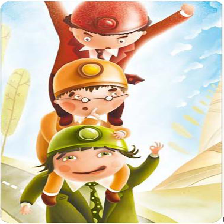

In [12]:
i = 50
img_list[i]

In [15]:
feat_list = [x.reshape(4096) for x in feat_list]
image_vectors = tools.encode_images(model, feat_list)
image_vectors_f30k = tools.encode_images(model_f30k, feat_list)

#### Берем топ-частотных слов

In [126]:
#words = pd.read_csv('words/4k_word_list.txt', sep = ',', header = -1)[0]
words = pd.read_csv('words/top1000_words.txt', sep = ',', header = -1).T[0]
words = np.array([x.replace(' ', '') for x in words])
words_vectors = tools.encode_sentences(model, words, verbose=True)
words_vectors_f30k = tools.encode_sentences(model_f30k, words, verbose=True)

1
1


In [127]:
words

array(['a', 'about', 'above', 'across', 'act', 'active', 'activity',
       'add', 'afraid', 'after', 'again', 'age', 'ago', 'agree', 'air',
       'all', 'alone', 'along', 'already', 'always', 'am', 'amount', 'an',
       'and', 'angry', 'another', 'answer', 'any', 'anyone', 'anything',
       'anytime', 'appear', 'apple', 'are', 'area', 'arm', 'army',
       'around', 'arrive', 'art', 'as', 'ask', 'at', 'attack', 'aunt',
       'autumn', 'away', 'baby', 'back', 'bad', 'bag', 'ball', 'bank',
       'base', 'basket', 'bath', 'be', 'bean', 'bear', 'beautiful', 'bed',
       'bedroom', 'beer', 'behave', 'before', 'begin', 'behind', 'bell',
       'below', 'besides', 'best', 'better', 'between', 'big', 'bird',
       'birth', 'birthday', 'bit', 'bite', 'black', 'bleed', 'block',
       'blood', 'blow', 'blue', 'board', 'boat', 'body', 'boil', 'bone',
       'book', 'border', 'born', 'borrow', 'both', 'bottle', 'bottom',
       'bowl', 'box', 'boy', 'branch', 'brave', 'bread', 'break',
   

##### Ищем ближайшие k слова к картинке, а потом смотрим, встретилась ли в топе близких к этим словам k картинкам, исходная картинка

In [128]:
tmp_is_pic_near_pic = []
k_range = [5,10]
k_mean = []
for k in k_range:
    print k
    for ind_pic in range(len(img_list)):
        ind_pic = 0
        mse_picture = np.array([mean_squared_error(image_vectors[ind_pic], x)
                                for x in words_vectors])
        idx_words = np.argpartition(mse_picture, k)
        is_pic_near_pic = []
        for ind_word in list(idx_words[:k]):
            mse_words = np.array([mean_squared_error(words_vectors_f30k[ind_word], x)
                                for x in image_vectors_f30k])
            idx_images = np.argpartition(mse_words, k)[:k]
            tmp_is_pic_near_pic.append(ind_pic in idx_images)
        is_pic_near_pic = np.mean(tmp_is_pic_near_pic)
    k_mean.append(np.mean(tmp_is_pic_near_pic))

5
10


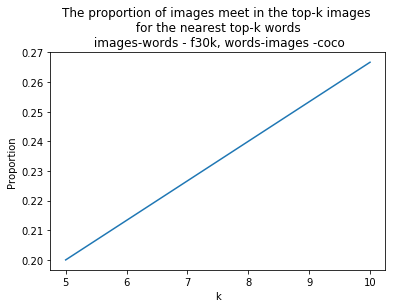

In [129]:
plt.plot(k_range, k_mean)
plt.title('The proportion of images meet in the top-k images \n for the nearest top-k words \n images-words - f30k, words-images -coco')
plt.xlabel('k')
plt.ylabel('Proportion')
plt.show()


### Пишем сетку

Берем 5 случайных картинок, из них выбираем одну

1) y - ohe номера картинки. 

2) X1 -  расстояние от картинки до топ 5 слов( часть речи, длина этих слов, сколько раз эти слова встречаются в топ-5 других картинок)

3) X2 - расстояние от полученного среднего вектора слов до 5 картинок, сколько раз картинки встречаются в топ-5 этих слов

4) Лосс - логлосс при обучении 2 игрока, при обучении 1 игрока - 1.5*p*(1-p)*(1-p) + p*p*(1-p)*1.5




### Строим модель

Матрица, в какой доле картинок слово в топ-5, расстояния от картинкок до слов

In [212]:
k = 10
idx_images_array = []
mse_images_array = []
mse_images_top_array = []
for i in range(len(words_vectors)):
    mse_words = np.array([mean_squared_error(words_vectors[i], x)
                                    for x in image_vectors])
    idx_images = np.argpartition(mse_words, k)[:k]
    idx_images_array.append([1 if x in idx_images else 0 for x in range(len(mse_words))])
    mse_images_array.append(mse_words)
    mse_images_top_array.append(mse_words[idx_images])
idx_images_array = np.array(idx_images_array)
mse_images_array = np.array(mse_images_array)
mse_images_top_array = np.array(mse_images_top_array)

In [216]:
i = 106
words[i]

'bridge'

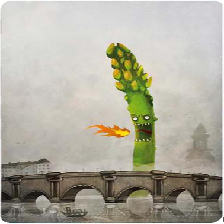

In [217]:
idx_images_array1 = np.array([mean_squared_error(words_vectors[i], x)
                                    for x in image_vectors])
ind = np.argpartition(idx_images_array1, k)[:k]
img_list[ind[0]]

In [218]:
norm_idx_images_array = idx_images_array.sum(axis = 0) / float(idx_images_array.sum())

Матрица, в какой доле слов, эта картинка в топ-5

In [219]:
k = 10
idx_words_array = []
mse_words_array = []
mse_words_top_array = []
for i in range(len(image_vectors)):
    mse_words = np.array([mean_squared_error(image_vectors[i], x)
                                    for x in words_vectors])
    idx_words = np.argpartition(mse_words, k)[:k]
    idx_words_array.append([1 if x in idx_words else 0 for x in range(len(mse_words))])
    mse_words_array.append(mse_words)
    mse_words_top_array.append(mse_words[idx_words])
idx_words_array = np.array(idx_words_array)
mse_words_array = np.array(mse_words_array)
mse_words_top_array = np.array(mse_words_top_array)

In [220]:
np.where(idx_words_array[0]==1)

(array([ 39,  76, 240, 317, 503, 560, 610, 778, 824, 995]),)

In [221]:
norm_idx_words_array = idx_words_array.sum(axis = 0) / float(idx_words_array.sum())

### Обучающая выборка

In [222]:
X_ind, y_ind, y, X1 = [], [], [], []
X_img_freq = []
num_samples = 100000
k = 10
for i in range(num_samples):
    X_ind.append(np.array(sample(range(1,len(img_list)), k)))
    y_ind.append(sample(X_ind[i], 1))
    y.append(np.array([1 if x==y_ind[i] else 0 for x in X_ind[i]]))
    dist_words = mse_words_top_array[y_ind[i]]
    freq_word = norm_idx_words_array[np.where(idx_words_array[0]==1)]
    X1.append(np.concatenate([dist_words.reshape(k,1), freq_word.reshape(k,1)], axis = 1))
    freq_image = norm_idx_images_array[np.where(idx_images_array[0]==1)]
    X_img_freq.append(freq_word)

In [223]:
idx_images_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [224]:
X2 = image_vectors[X_ind].reshape(num_samples,1024,k)
X1 = np.array(X1).reshape(num_samples,2,k)
y = np.array(y).reshape(num_samples,1,k)
X3 = X2.reshape(num_samples,k,1024)
X30 = X3[:,0,:].reshape(num_samples,1024)
X31 = X3[:,1,:].reshape(num_samples,1024)
X_img_freq = np.array(X_img_freq)

In [225]:
def mean_squared_error_keras(y_true, y_pred):
    return K.mean(K.square(y_pred - y_true), axis=2)

### Сетка, которая пока просто подбирает идеальное слово под случайно выбранную картинку для 1 агента,  а потом 2 агент просто выбирает ближайшее слово (или учит как выбирать dense слоем (тоже такой штраф за небанальность))

In [377]:
k = 10
from keras.models import Model
import keras.backend as K
from keras.layers import Conv1D, Reshape, Conv2D,Input, Dense, dot, multiply, add, concatenate, Lambda
# Сетка, которая пока просто подбирает идеальное слово под случайно выбранную картинку для 1 агента, 
# а потом 2 агент просто выбирает ближайшее слово

# Входы 10 ближайших пар, заранее сгенерированные расстояния между ближайшими словами и картинками, и частоту топ 10 
# близости каждого слова к ближайшим 10 картинкам
inputs1 = Input(shape=(2,k))
# Эмбеддинги для слов
inputs2 = Input(shape=(1024,k))
inputs21 = Input(shape=(k,1024))
# OHE-вектор, какое слово было истинным
inputs3 = Input(shape=(1,k))
#  Учим свертку, которая делает штраф-поощрения за банальность (дистанция между словами, попсовость слов)
# На выходе получили веса для каждого слова
conv1d = Conv1D(k, (2), activation='softmax', padding = 'valid')(inputs1)
#predictions = Dense(5, activation='softmax')(conv1d)
# усредняем слова с весами, выученными сверткой
merge_layer = multiply([conv1d, inputs2])
# делаем повтор, чтобы потом считать новые минимальные дистанции
sum_layer = Lambda(lambda x: K.repeat(K.sum(x, axis = 2), k), output_shape=(1024, k))(merge_layer)

# считаем разницу между полученными средними одного и другого
distance_layer = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,k))([inputs21, sum_layer])
#features_img = concatenate([distance_layer, inputs3], axis = 1)
#output = Conv1D(5, (2), activation='softmax', padding = 'valid')(features_img)

# Выбираем правильный ответ (аналог агента)
output = Dense(k, activation='softmax')(distance_layer)

#подбираем картинки
model_keras = Model(inputs=[inputs1, inputs2, inputs21], outputs=output)
model_keras.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])





In [227]:
model_keras.fit([X1, X2, X2.reshape(num_samples, k,1024)],y, epochs = 10, 
                verbose = True, batch_size = 500, )

Epoch 1/1000
100000/100000 [==============================] - 50s 501us/step - loss: 115.1310 - acc: 0.0975
Epoch 2/1000
100000/100000 [==============================] - 53s 531us/step - loss: 115.1301 - acc: 0.1005
Epoch 3/1000
100000/100000 [==============================] - 49s 491us/step - loss: 115.1300 - acc: 0.1011
Epoch 4/1000
100000/100000 [==============================] - 52s 516us/step - loss: 115.1304 - acc: 0.1004
Epoch 5/1000
100000/100000 [==============================] - 51s 509us/step - loss: 115.1299 - acc: 0.1008
Epoch 6/1000
100000/100000 [==============================] - 54s 537us/step - loss: 115.1306 - acc: 0.1014
Epoch 7/1000
100000/100000 [==============================] - 52s 517us/step - loss: 115.1296 - acc: 0.1010
Epoch 8/1000
 10000/100000 [==>...........................] - ETA: 42s - loss: 115.1346 - acc: 0.0947

KeyboardInterrupt: 

#### Отрисовать сетку

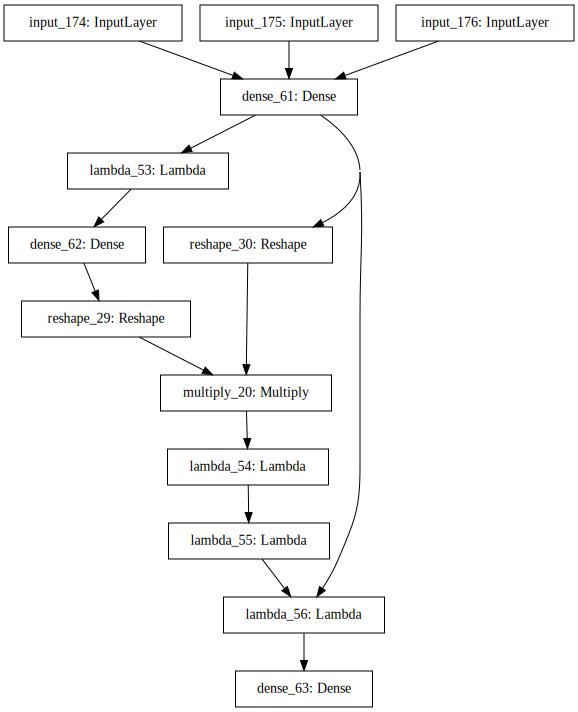

In [405]:
from keras.utils import plot_model
#plot_model(model_keras, to_file='models/model.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model_hard).create(prog='dot', format='svg' ))


### Сетка, которая доучивает еще dense слой к эмбеддингам

In [ ]:
# Датасет - подготавливаем наборы из 10 картинок , выбираем из них случайно одну
num_samples = 10000
k = 10
num_words = 998
X_images = []
y_true_image = []
for i in range(num_samples):
    img = np.array(sample(range(1,len(img_list)), k))
    X_images.append(img)
    true_image = sample(img, 1)
    y_true_image.append(np.array([1 if x==true_image else 0 for x in X_images[i]]))
# Эмбеддинги для всех картинок
X_images = image_vectors[X_images].reshape(num_samples,1024,k)
# Эмбеддинги для правильной картинки, размноженные 10 раз
t =np.array(X_images)[:,:,np.argmax(y_true_image)]
X_true_img = np.repeat(t.reshape(t.shape[0],t.shape[1],1),num_words,axis =2).reshape(num_samples, num_words, 1024)
# Эмбеддинги для всех текстов
X_all_texts = np.repeat(words_vectors.reshape(1, num_words, 1024),num_samples, axis = 0 )
# Решейплю
X_images = X_images.reshape(num_samples, k,1024)
# Ответы
y_true_image = np.array(y_true_image).reshape(num_samples,1, k)

In [459]:
emb_dim = 100

# Вектора для k картинок
X_images_net = Input(shape=(k,1024))
# Вектор для правильной картинки, размноженной 1000 раз - по количеству слов
X_image_true_net = Input(shape=(num_words, 1024))
# Вектора для всех слов
X_text_all_net = Input(shape = (num_words, 1024))
# Вектор для того, какая картинка была авторской
y_true_image_net = Input(shape=(1,k))


conv_img_words2 = Dense(100, activation = 'softmax')#(X_image_true_net, X_text_all_net)
# Эмбеддинги для правильной картинки (размноженной по числу слов)
image_net2 = conv_img_words2(X_image_true_net)
# Эмбединги для слов
word_net2 = conv_img_words2(X_text_all_net)
# Считаю расстояния от картинки до текста, представляю картинку как взвешенную сумму слов
distance_layer2 = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,num_words))([image_net2, word_net2])
weights_for_words2 = Dense(num_words, activation='softmax')(distance_layer2)
# Меняем форму слоев, чтобы их перемножить
weights_for_words2_resh = Reshape((1,num_words))(weights_for_words2)
word_net2_resh = Reshape((emb_dim,num_words))(word_net2)
# Перемножаем
merge_layer2 = multiply([weights_for_words2_resh, word_net2_resh])
# Усредняем, получаем вектор для финального слова
sum_layer2 = Lambda(lambda x: K.sum(x, axis = 2), output_shape=(1,emb_dim))(merge_layer2)
# Обрабатываем Dense слоем k картинок
image_all_net2 = conv_img_words2(X_images_net)
# Размножаем вектор для финального слова
final_word_vector_k = Lambda(lambda x: K.repeat(x, k), output_shape=(10, emb_dim))(sum_layer2)
# Считаем расстояния от полученного вектора слов до k картинок
distance_layer_final = Lambda(lambda x: mean_squared_error_keras(x[0], x[1]),
                        output_shape=(1,k))([image_all_net2, final_word_vector_k])
# Подаем в Dense
output2 = Dense(k, activation='softmax')(distance_layer_final)

#подбираем картинки
model_hard = Model(inputs=[X_images_net, X_image_true_net, X_text_all_net], outputs=output2)
model_hard.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



# Бейзлайн - количество угаданных слов или лосс по фиксированным image captioning эмбеддингам

In [ ]:
model_hard.fit([X_images, X_true_img, X_all_texts],y_true_image, epochs = 5, 
                verbose = True, batch_size = 500, )

In [413]:
X_images.shape, X_images_net

((50, 1024, 10), <tf.Tensor 'input_178:0' shape=(?, 10, 1024) dtype=float32>)

In [425]:
X_true_img.shape, X_image_true_net

((50, 998, 1024), <tf.Tensor 'input_183:0' shape=(?, 998, 1024) dtype=float32>)

In [445]:
X_all_texts.shape, X_text_all_net

((50, 998, 1024), <tf.Tensor 'input_192:0' shape=(?, 998, 1024) dtype=float32>)

In [451]:
y_true_image.shape, output2

((1, 50, 10), <tf.Tensor 'dense_81/Softmax:0' shape=(?, 10) dtype=float32>)

# Черновик

In [ ]:


model = VGG19(weights='imagenet', include_top=False)

img_path = 'images/' + path
img = image.load_img(img_path, target_size=(500, 500))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

features = model.predict(x)

#### Берем картинки из тестового сета

In [ ]:
images_coco = np.load('data_coco_flkr/coco_test_ims.npy')

In [ ]:
k = 400
plt.imshow(images_coco[k].reshape(64,64,1))
plt.show()

In [ ]:
%pylab inline
# чуть покрасивше картинки:
#pd.set_option('display.mpl_style', 'default')
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = 8, 6
plt.rcParams['axes.grid'] = True
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Ubuntu'
plt.rc('text', usetex=False)
plt.rc('font', family='serif')
plt.rc('font', weight='bold')
plt.rc('xtick', labelsize=10) 
plt.rc('ytick', labelsize=10)
# чтобы был русский шрифт
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

